DCC207 -- Algoritmos 2

# Trabalho Prático 1 -- Geometria computacional

Prof. Renato Vimieiro

Aluno: Henrique Matos de Vasconcellos



# Problema da Galeria de Arte
O problema da galeria de arte consiste em instalar câmeras de segurança de forma a cobrir todos os cômodos da galeria, utilizando o menor número possível de câmeras. Embora a galeria seja tridimensional, o problema pode ser simplificado modelando-a como um polígono em um plano bidimensional. As câmeras tem a capacidade de cobrir toda a área de um cômodo e também partes de outros cômodos, exceto quando há obstruções devido às paredes.

Polígonos mais complexos, com um maior número de vértices, geralmente requerem mais câmeras para garantir cobertura total. A complexidade do polígono também afeta a dificuldade de vigilância; por exemplo, um polígono convexo pode ser monitorado com uma única câmera, enquanto polígonos não convexos podem necessitar de múltiplas câmeras.

Determinar o número ótimo de câmeras é um problema computacionalmente difícil. Por isso, investiga-se limites inferiores para os piores casos, assegurando uma solução que, mesmo não sendo ótima em todos os casos, seja adequada para qualquer configuração da galeria.

# Bibliotecas


In [262]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from matplotlib.path import Path
import plotly.graph_objs as go
import numpy as np
import copy

## Classes

In [263]:
class VerticeGrafo:
    def __init__(self, numero):
        self.numero = numero  # Número do vértice
        self.arestas = []      # Lista de arestas (números dos outros vértices aos quais este vértice está ligado)

    def adicionar_aresta(self, vertice):
        if vertice not in self.arestas:
            self.arestas.append(vertice.numero)  # Adiciona o número do vértice à lista de arestas


class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.orelha = False
        self.cor = 0

    def print(self):
        print(f"Ponto: ({self.x}, {self.y}), Ponta de orelha: {self.orelha}, Cor: {self.cor}")

class SegmentoReta:
    def __init__(self, ponto1, ponto2):
        self.ponto1 = ponto1
        self.ponto2 = ponto2
        self.is_diagonal = False

    def print(self):
        print(f"Segmento de reta: ({self.ponto1.x}, {self.ponto1.y}) -> ({self.ponto2.x}, {self.ponto2.y}), Diagonal: {self.is_diagonal}")


class Poligono:
    def __init__(self, vertices):
        self.num_vertices = len(vertices)
        self.seguimentos = []
        self.vertices = vertices
        for i in range(self.num_vertices):
            self.seguimentos.append(SegmentoReta(vertices[i], vertices[(i + 1) % self.num_vertices]))
        for i in range(self.num_vertices):
            self.seguimentos.append(SegmentoReta(vertices[i], vertices[(i + 1) % self.num_vertices]))

    def print(self):
        print(f"Polígono com {self.num_vertices} vértices e os seguintes segmentos de reta:")
        for segmento in self.seguimentos:
            segmento.print()
    def plotar(self):
        fig, ax = plt.subplots()
        for segmento in self.seguimentos:
            x_values = [segmento.ponto1.x, segmento.ponto2.x]
            y_values = [segmento.ponto1.y, segmento.ponto2.y]
            ax.plot(x_values, y_values, 'bo-')  # blue color, circle markers, solid line

        # Adicionando anotações para os vértices
        for i, vertice in enumerate(self.vertices):
            ax.text(vertice.x, vertice.y, str(i), fontsize=12, ha='right')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    #Parte para o Ear-Clipping

    def segmento_a_esquerda(self, index1, index2):
        """
        Verifica se o segmento no index1 está à esquerda do segmento no index2.
        Os segmentos são orientados e têm um ponto em comum.
        """
        p0 = self.vertices[index1]
        p1 = self.vertices[(index1 + 1) % self.num_vertices]
        p2 = self.vertices[(index2 + 1) % self.num_vertices]

        # Calcula o produto vetorial
        cross_product = (p1.x - p0.x) * (p2.y - p0.y) - (p1.y - p0.y) * (p2.x - p0.x)

        if cross_product > 0:
            return True
        elif cross_product < 0:
            return False
        else:
            return None  # Colineares
    def ponto_dentro_triangulo(self, p, p0, p1, p2):
        """
        Verifica se o ponto p está dentro do triângulo formado por p0, p1 e p2.
        """
        path = Path([(p0.x, p0.y), (p1.x, p1.y), (p2.x, p2.y)])
        return path.contains_point((p.x, p.y))

    def vertice_dentro_triangulo(self, index):
        """
        Verifica se há algum vértice dentro do triângulo formado pelos três vértices consecutivos
        começando no índice fornecido.
        """
        p0 = self.vertices[index]
        p1 = self.vertices[(index + 1) % self.num_vertices]
        p2 = self.vertices[(index + 2) % self.num_vertices]

        for i in range(self.num_vertices):
            if i not in [index, (index + 1) % self.num_vertices, (index + 2) % self.num_vertices]:
                if self.ponto_dentro_triangulo(self.vertices[i], p0, p1, p2):
                    return True
        return False
    def verificar_ponta_orelha(self, index):
        """
        Verifica se o vértice no índice fornecido é uma ponta de orelha.
        """
        prev_index = (index - 1) % self.num_vertices
        next_index = (index + 1) % self.num_vertices

        if self.segmento_a_esquerda(prev_index, index) and not self.vertice_dentro_triangulo(prev_index):
            self.vertices[index].orelha = True
        else:
            self.vertices[index].orelha = False
        return self.vertices[index].orelha

    def verificar_pontas_orelha(self, plotar=False):
        frames = []
        for index in range(self.num_vertices):
            prev_index = (index - 1) % self.num_vertices
            next_index = (index + 1) % self.num_vertices
            self.verificar_ponta_orelha(index)

            # Plotando o triângulo atual
            if plotar:
                x = [self.vertices[prev_index].x, self.vertices[index].x, self.vertices[next_index].x, self.vertices[prev_index].x]
                y = [self.vertices[prev_index].y, self.vertices[index].y, self.vertices[next_index].y, self.vertices[prev_index].y]

                fig = go.Figure()

                # Adiciona os segmentos do polígono
                for segmento in self.seguimentos:
                    fig.add_trace(go.Scatter(x=[segmento.ponto1.x, segmento.ponto2.x], y=[segmento.ponto1.y, segmento.ponto2.y],
                                             mode='lines+markers', line=dict(color='blue')))

                # Adiciona o triângulo atual
                fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers', line=dict(color='red', dash='dash'), fill='toself'))

                # Adiciona a cor para os vértices que são pontas de orelha
                for i, vertice in enumerate(self.vertices):
                    if i == index:
                        fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='yellow', size=10)))  # Vértice em análise
                    elif vertice.orelha:
                        fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='green', size=10)))
                    else:
                        fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='blue', size=10)))

                frames.append(go.Frame(data=fig.data))

        if plotar:
            fig = go.Figure(
                data=frames[0].data,
                layout=go.Layout(
                    updatemenus=[dict(type='buttons', showactive=True,
                                      buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, {'frame': {'duration': 6000, 'redraw': True},
                                                                 'fromcurrent': True, 'transition': {'duration': 1000}}]),
                                               dict(label='Pause',
                                                    method='animate',
                                                    args=[[None], {'frame': {'duration': 1000, 'redraw': False},
                                                                   'mode': 'immediate',
                                                                   'transition': {'duration': 1000}}])
                                              ])],
                    xaxis=dict(range=[min(vertice.x for vertice in self.vertices) - 1, max(vertice.x for vertice in self.vertices) + 1]),
                    yaxis=dict(range=[min(vertice.y for vertice in self.vertices) - 1, max(vertice.y for vertice in self.vertices) + 1]),
                    title="Verificação de Pontas de Orelha",
                    showlegend=False
                ),
                frames=frames
            )
            fig.show()

    def remover_vertice(self, index):
        if self.num_vertices <= 3:
            raise ValueError("Não é possível remover vértices de um polígono com 3 ou menos vértices.")

        prev_index = (index - 1) % self.num_vertices
        next_index = (index + 1) % self.num_vertices

        # Remove os segmentos que envolvem o vértice a ser removido
        self.seguimentos = [seg for seg in self.seguimentos if seg.ponto1 != self.vertices[index] and seg.ponto2 != self.vertices[index]]

        # Adiciona o novo segmento ligando o antecessor ao sucessor
        self.seguimentos.append(SegmentoReta(self.vertices[prev_index], self.vertices[next_index]))

        # Remove o vértice da lista
        self.vertices.pop(index)

        # Atualiza o número de vértices
        self.num_vertices -= 1

    def finalizar_triangulacao(self, plotar=False):
        poligono_temp = copy.deepcopy(self)
        diagonais = []
        triangulos = []

        frames = []

        while poligono_temp.num_vertices > 3:
            for index in range(poligono_temp.num_vertices):
                if poligono_temp.vertices[index].orelha:
                    prev_index = (index - 1) % poligono_temp.num_vertices
                    next_index = (index + 1) % poligono_temp.num_vertices

                    # Adiciona a diagonal
                    diagonal = SegmentoReta(poligono_temp.vertices[prev_index], poligono_temp.vertices[next_index])
                    diagonal.is_diagonal = True  # Marca a diagonal
                    diagonais.append(diagonal)

                    # Adiciona o triângulo formado pelos vértices prev_index, index e next_index
                    triangulo = Poligono([poligono_temp.vertices[prev_index], poligono_temp.vertices[index], poligono_temp.vertices[next_index]])
                    triangulos.append(triangulo)

                    poligono_temp.remover_vertice(index)

                    # Atualiza o status dos vértices adjacentes
                    if prev_index < index:
                        poligono_temp.verificar_ponta_orelha(prev_index)
                    if next_index > index:
                        poligono_temp.verificar_ponta_orelha(next_index - 1)
                    else:
                        poligono_temp.verificar_ponta_orelha(next_index)

                    if plotar:
                        fig = go.Figure()

                        # Adiciona os segmentos do polígono
                        for segmento in poligono_temp.seguimentos:
                            fig.add_trace(go.Scatter(x=[segmento.ponto1.x, segmento.ponto2.x], y=[segmento.ponto1.y, segmento.ponto2.y],
                                                     mode='lines+markers', line=dict(color='blue')))

                        # Marca os vértices
                        for i, vertice in enumerate(poligono_temp.vertices):
                            if i == prev_index or i == next_index:
                                fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='yellow', size=10)))
                            elif vertice.orelha:
                                fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='green', size=10)))
                            else:
                                fig.add_trace(go.Scatter(x=[vertice.x], y=[vertice.y], mode='markers', marker=dict(color='blue', size=10)))

                        frames.append(go.Frame(data=fig.data))
                    break  # Reinicia a iteração após a remoção de um vértice

        # Adiciona o último triângulo formado pelos 3 vértices restantes
        ultimo_triangulo = Poligono([poligono_temp.vertices[0], poligono_temp.vertices[1], poligono_temp.vertices[2]])
        triangulos.append(ultimo_triangulo)

        if plotar:
            fig = go.Figure(
                data=frames[0].data,
                layout=go.Layout(
                    updatemenus=[dict(type='buttons', showactive=True,
                                      buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, {'frame': {'duration': 6000, 'redraw': True},
                                                                 'fromcurrent': True, 'transition': {'duration': 6000}}]),
                                               dict(label='Pause',
                                                    method='animate',
                                                    args=[[None], {'frame': {'duration': 1000, 'redraw': False},
                                                                   'mode': 'immediate',
                                                                   'transition': {'duration': 1000}}])
                                              ])],
                    xaxis=dict(range=[min(vertice.x for vertice in self.vertices) - 1, max(vertice.x for vertice in self.vertices) + 1]),
                    yaxis=dict(range=[min(vertice.y for vertice in self.vertices) - 1, max(vertice.y for vertice in self.vertices) + 1]),
                    title="Triangulação do Polígono",
                    showlegend=False
                ),
                frames=frames
            )
            fig.show()
        grafo_final = Grafo(self.vertices, self.seguimentos + diagonais, triangulos)
        return grafo_final

class Grafo:
    def __init__(self, pontosTP, segmentosTP, triangulos):
        self.pontosTP = pontosTP
        self.segmentosTP = segmentosTP
        self.triangulos = triangulos
        self.vertices = [VerticeGrafo(i) for i in range(len(triangulos))]  # Cria um VerticeGrafo para cada triângulo


    def plotarTP(self):
        fig, ax = plt.subplots()
        for segmento in self.segmentosTP:
            x_values = [segmento.ponto1.x, segmento.ponto2.x]
            y_values = [segmento.ponto1.y, segmento.ponto2.y]
            if segmento.is_diagonal:
                ax.plot(x_values, y_values, 'bo--')
            else:
                ax.plot(x_values, y_values, 'bo-')

        for i, ponto in enumerate(self.pontosTP):
            ax.text(ponto.x, ponto.y, str(i), fontsize=12, ha='right')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def plotar_triangulos(self):
        fig, ax = plt.subplots()
        for idx, triangulo in enumerate(self.triangulos):
            x_values = [ponto.x for ponto in triangulo.vertices] + [triangulo.vertices[0].x]
            y_values = [ponto.y for ponto in triangulo.vertices] + [triangulo.vertices[0].y]
            ax.plot(x_values, y_values, 'bo-')
            ax.fill(x_values, y_values, alpha=0.2)

            centro_x = sum(ponto.x for ponto in triangulo.vertices) / 3
            centro_y = sum(ponto.y for ponto in triangulo.vertices) / 3
            ax.text(centro_x, centro_y, str(idx), fontsize=12, ha='center')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

# Leitura e Plot do Polígono

Exemplos de polígonos usados na construção do relatório foram obtidos de
https://www.ic.unicamp.br/~cid/Problem-instances/Art-Gallery/AGPVG/index.html.

In [264]:
def ler_poligono(url):
    response = requests.get(url)

    conteudo = response.text.strip()
    partes = conteudo.split()
    num_vertices = int(partes[0])

    # Lista de pontos
    vertices = []
    for i in range(1, len(partes), 2):
        x = partes[i]
        y = partes[i + 1]
        x_num, x_den = map(int, x.split('/'))
        y_num, y_den = map(int, y.split('/'))
        ponto = Ponto(x_num / x_den, y_num / y_den)
        vertices.append(ponto)

    # Criando e retornando o polígono
    poligono = Poligono(vertices)
    return poligono


# Triangulação de Polígonos

Basicamente, o problema de triangulação consiste em dividir o polígono em triângulos,usando um conjunto máximo de diagonais que não se interceptam. No caso uma diagonal é um segmento conectando dois vértices do polígono que se encontra estritamente dentro do polígono.


Como existe um teorema de que todo polígono simples possui pelo menos uma triangulação, e toda triangulação de um polígono simples com n vértices consiste em exatamente n-2 triângulos; o problema da galeria de arte pode ser resolvido usando uma triangulação.


Dessa forma, pode-se posicionar as câmeras em vértices específicos pois assim uma câmera pode cobrir mais de um triângulo o que deixa o numero de cameras menor que n-2. Ao aplicar coloração de grafos ao problema, como será mostrado, é possível garantir que n/3 cameras é um número suficiente para resolver o problema.  

# Ear-Clipping

O Ear-Clipping é um algoritmo de triangulação de tempo quadrático que consiste em cortar as pontas de orelhas do polígono. Uma orelha de um polígono é o triângulo formado pelos vértices consecutivos u, v, w, tal que uw é uma diagonal, nesse caso, v é chamado de ponta da orelha

#Exemplo iterativo


A seguir uma demonstração interativa de como funciona o algoritmo feita com a seguinte instância do problema:   



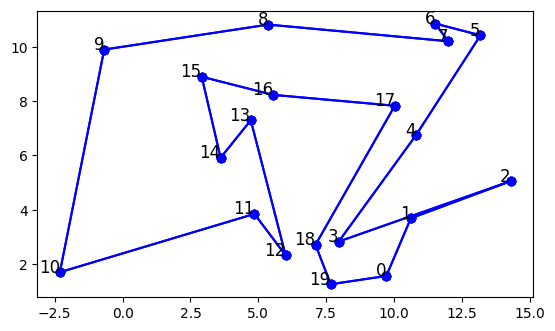

In [265]:
# Exemplo
url = "https://raw.githubusercontent.com/henriquemv23/Polygons/main/randsimple-20-10.pol"
poligono = ler_poligono(url)
poligono.plotar()

# Identificando Pontas

O primeiro passo do algoritmo é verificar para cada vértice do polígono se ele é ponta de orelha ou não.Seja Pi um vértice, Pi-1 seu antecessor e Pi+1 seu sucessor, Pi é uma ponta de orelha se:

1)Pi-1Pi está a esquerda de PiPi+1 **e**

2)Não há nenhum outro vértice dentro do triângulo Pi-1PiPi+1.

Na animação a seguir cada iteração é mostrada, com o vertice em analise ficando amarelo. Após a análise se é identificado que o vértice é ponta de orelha ele fica verde, caso contrário volta a ser azul. Para ver a animação basta dar play, sendo que ela pode ser pausada a qualquer momento, caso o leitor queira verificar as condições.
   


In [266]:
# Verificando todas as pontas de orelha e plotando o processo
poligono.verificar_pontas_orelha(plotar=True)

# Remoção de Pontas


O próximo passo consiste em percorrer o polígono em ordem e ao avistar uma ponta de orelha, remove-la. Após a remoção desse vértice que era ponta de orelha (Pi), a diagonal que liga o antecessor de Pi e o sucessor de PI no polígono atual(após possíveis remoções) é considerada para a triangulação. Também após a remoção o status desses dois vértices adjacentes é atualizado pois eles podem ter virado ponta de orelha ou deixado de ser. Todo esse processo é repetido enquanto o número de vértices for maior que três.

A animação mostra a remoção das pontas de triângulo com o vértice em análise ficando em amarelo, os de verde sendo os que são ponta de orelha e os de azul os que não são.

In [267]:
triangularizado = poligono.finalizar_triangulacao(plotar=True)

# Resultado da triangulação:

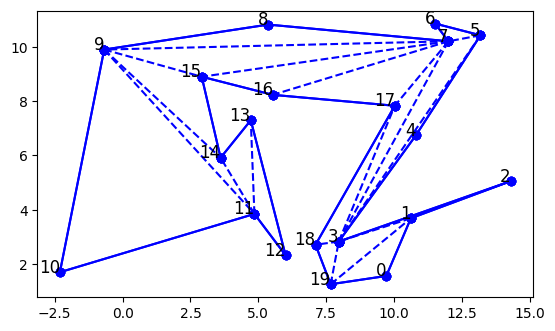

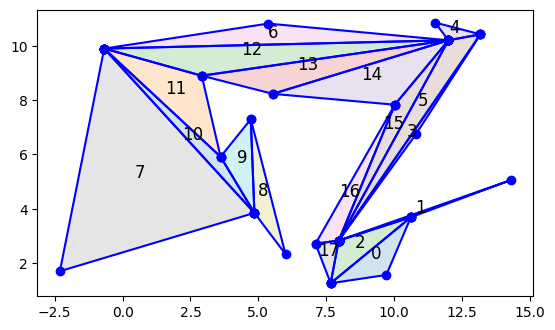

In [269]:
triangularizado.plotarTP()
triangularizado.plotar_triangulos()

# Coloração do grafo

Agora que a triangulação foi feita, sendo P o polígono e T(P) sua triangulação o proximo passo é considerar o grafo G(P) em que os vértices são os triângulos e as arestas se eles compartilham uma diagonal.
É possível colorir os vértices de T(P), fazendo uma busca em profundidade em G(P), para isso inicia-se a busca em um vértice arbitrário de G(P). Nesse momento, cada vértice do triângulo é colorido equivalente com uma cor (branco, preto e cinza). Quando o próximo vértice de G(P) é visitado , haverá apenas uma escolha para a cor do vértice restante do triângulo equivalente, pois os outros dois são compartilhados com o triângulo anterior. No fim, o resultado é uma 3-coloração de T(P).
Assim ao escolher a partição com o menor número de vértices para posicionar as câmeras, essa escolha resulta em um total de n/3 câmeras.
